# **Modeling and Evaluation**


**Objectives**

* Build a pipeline that transforms features and trains multiple regression models
* Evaluate model performance and choose the best one

**Inputs**

* A cleaned dataset with house features and sale prices:  
  `outputs/datasets/cleaned/TrainSetCleaned.csv`

**Outputs**

* Best trained regression model
* Model evaluation scores (R², MAE, RMSE)
* Actual vs Predicted plot


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-house-price-predictor/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-house-price-predictor'

# Load Data


In this step:
- We load the cleaned dataset from the previous stage.
- We split the dataset into training (80%) and test (20%) sets.
- We will train our models on the training set and test them on the test set.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the cleaned dataset
df = pd.read_csv("outputs/datasets/cleaned/TrainSetCleaned.csv")

# Define the target (what we want to predict) and features (what we use to predict it)
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (934, 21)
Test set shape: (234, 21)


---

# Create ML Pipeline

In this step, we build a full ML pipeline. The pipeline includes:
1. **Imputation** – fills missing values for both categorical and numerical columns.
2. **Ordinal Encoding** – converts categories like "Gd", "TA", "Fa" into numbers.
3. **Transformations** – applies log and Yeo-Johnson transformations to fix skewed features.
4. **Correlation Filtering** – removes highly correlated features to reduce redundancy.
5. **Standard Scaling** – ensures features are on a similar scale.
6. **Feature Selection** – selects important features using the model.
7. **Model** – fits a regression model to predict SalePrice.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import YeoJohnsonTransformer, LogTransformer
from feature_engine.selection import SmartCorrelatedSelection

def build_pipeline(model):
    return Pipeline([
        # Step 1: Impute missing values
        ("categorical_imputer", CategoricalImputer(
            imputation_method='missing', fill_value='None',
            variables=['GarageFinish', 'BsmtFinType1', 'BsmtExposure', 'KitchenQual']
        )),
        ("median_imputer", MeanMedianImputer(
            imputation_method='median',
            variables=['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']
        )),

        # Step 2: Encode categorical features
        ("ordinal_encoder", OrdinalEncoder(
            encoding_method='arbitrary',
            variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
        )),

        # Step 3: Apply transformations
        ("yeojohnson", YeoJohnsonTransformer(variables=["LotArea", "GrLivArea", "TotalBsmtSF"])),
        ("log_transform", LogTransformer(variables=["1stFlrSF"])),

        # Step 4: Filter correlated features and scale
        ("correlation_filter", SmartCorrelatedSelection(
            method="spearman", threshold=0.8, selection_method="variance"
        )),
        ("scaler", StandardScaler()),

        # Step 5: Select important features
        ("feature_selector", SelectFromModel(model)),

        # Step 6: Regressor
        ("regressor", model)
    ])

---

# Define Models and Hyperparameters

We will train and compare multiple regression models:
- Linear Regression
- Random Forest Regressor
- Gradient Boosting Regressor
- XGBoost Regressor

We also define hyperparameters to test for each model.
These will be passed into GridSearchCV to find the best combination.

In [8]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Dictionary of models to try
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

# Dictionary of hyperparameters for each model
params = {
    "LinearRegression": {},
    "RandomForestRegressor": {
        "regressor__n_estimators": [50, 100, 150],
        "regressor__max_depth": [None, 5, 15],
        "regressor__min_samples_split": [2, 5, 10],
    },
    "GradientBoostingRegressor": {
        "regressor__n_estimators": [100],
        "regressor__learning_rate": [0.1, 0.01]
    },
    "XGBRegressor": {
        "regressor__n_estimators": [100],
        "regressor__learning_rate": [0.1, 0.01]
    },
}

---

# GridSearchCV Training

Now we train each model using a grid search:
- We pass the model pipeline and hyperparameters into `GridSearchCV`.
- It will test all combinations using 5-fold cross-validation.
- We store the best result for each model in a dictionary.

**Hyperparameter tuning for Random Forest**

We perform an extended grid search using:
- `n_estimators` (number of trees): [50, 100, 150]
- `max_depth` (tree depth): [None, 5, 15]
- `min_samples_split` (minimum samples to split a node): [2, 5, 10]

This results in 27 combinations for Random Forest. The grid search will test them using 5-fold cross-validation to find the best configuration.

In [9]:
results = {}

for name, model in models.items():
    print(f"\nTraining: {name}")
    pipeline = build_pipeline(model)
    grid = GridSearchCV(
        pipeline,
        param_grid=params[name],
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    results[name] = grid


Training: LinearRegression


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype i


Training: RandomForestRegressor


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype


Training: GradientBoostingRegressor


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype


Training: XGBRegressor


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype

In [10]:
# Print best hyperparameters and score for Random Forest
print("Best hyperparameters for Random Forest:")
print(results["RandomForestRegressor"].best_params_)

print("\nBest cross-validated R² score:")
print(results["RandomForestRegressor"].best_score_)

Best hyperparameters for Random Forest:
{'regressor__max_depth': None, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100}

Best cross-validated R² score:
0.8005451720982929


---

# Evaluate Best Model

Now we:
1. Find the model with the highest mean cross-validation score.
2. Use it to make predictions on the test set.
3. Print performance metrics:
   - R² (explained variance)
   - MAE (mean absolute error)
   - RMSE (root mean squared error)

In [11]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Find the model with the best average score
best_model_name = max(results, key=lambda name: results[name].best_score_)
best_pipeline = results[best_model_name].best_estimator_

print(f"Best model: {best_model_name}")

# Make predictions on the test set
y_pred = best_pipeline.predict(X_test)

# Print performance metrics
print("R² Score:", r2_score(y_test, y_pred).round(3))
print("MAE:", mean_absolute_error(y_test, y_pred).round(3))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)).round(3))

Best model: LinearRegression
R² Score: 0.812
MAE: 23069.738
RMSE: 33647.476


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype i

---

# Prediction vs Actual Plot


We now visualize how well the model predicted house prices:
- The x-axis shows the **actual SalePrice**.
- The y-axis shows the **predicted SalePrice**.
- The red line shows **perfect predictions** (where predicted = actual).

The closer the dots are to the red line, the better the model.

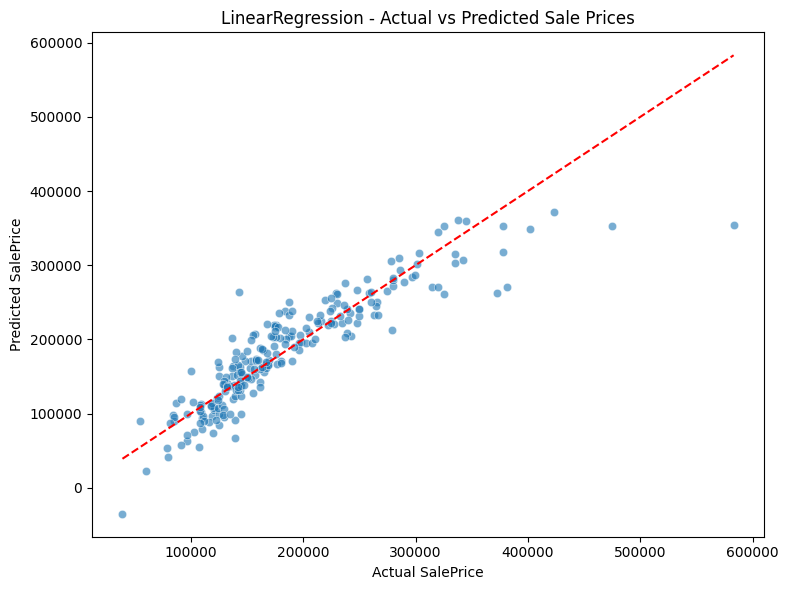

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title(f"{best_model_name} - Actual vs Predicted Sale Prices")
plt.tight_layout()
plt.show()

---


## Final Summary

In this notebook, we:

- Loaded a cleaned dataset of house prices  
- Built a full ML pipeline with imputation, encoding, and transformations  
- Trained and compared multiple regression models using GridSearchCV  
- Selected the best model based on cross-validation  
- Evaluated its performance on the test set using R², MAE, and RMSE  
- Visualized actual vs predicted prices to interpret performance  

## Save the best model pipeline

We can save the best trained pipeline to use later in deployment or prediction scripts.

In [13]:
import joblib
import os

# Create output folder if it doesn't exist
os.makedirs("outputs/models", exist_ok=True)

# Save the best model pipeline
joblib.dump(best_pipeline, f"outputs/models/{best_model_name}_pipeline.pkl")
print(f"Model saved to: outputs/models/{best_model_name}_pipeline.pkl")

Model saved to: outputs/models/LinearRegression_pipeline.pkl


---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
